# Initial Design

Previously, I tried doing an initial design using the full descriptor set, but found it didn't spread throughout the space well. Therefore, I am using the principal component space for the initial design. 

Also, I will need to evaporate the solvents, so it is best to not choose solvents with a really high boiling point (>140°C).  Conversely, if the boiling point of the solvent is too low, it will be really difficult to run the reaction since it won't be possible to achieve the needed reaction temeprature (120°C) without putting all the solvent in the gas phase (even with a pressurized reaction vessel + refluxing). So, I'm choosing to limit the optimization to solvents with boiling points between 80°C and 140°C.

Finally, I am limiting to solvents available in the lab since I am on a time constraint.

## 1. Load Dependencies

In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from safety_data import get_safety_data 
from summit.data import solvent_ds, ucb_ds, DataSet
from summit.domain import Domain, DescriptorsVariable, ContinuousVariable
from summit.initial_design import LatinDesigner, RandomDesigner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import pickle

In [9]:
#This part is to load solvents available from cheminventory
# You can still reproduce the notebook without cheminventory because the available solvents
# will be loaded from a file

%load_ext dotenv
%dotenv
from cheminventory import ChemInventory
import pickle
from tqdm import tqdm_notebook
ci = ChemInventory() #username and password loaded from environmental variables (.env file)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


## 2. Set up domain

In [10]:
#Read in solubility data
solubilities = pd.read_csv('inputs/solubilities.csv')
solubilities = solubilities.set_index('cas_number')
solubilities = DataSet.from_df(solubilities)
solvent_ds_full = solvent_ds.join(solubilities)
solubilities.head(5)

,solubility
cas_number,
98-07-7,-5.348250
111-78-4,-6.310797
5194-51-4,-6.592425
98-87-3,-0.808447
2004-70-8,-6.135296


In [11]:
#Calculate principal components
solvent_select = solvent_ds_full[(solvent_ds_full['boiling_point']>80) & 
                                   (solvent_ds_full['boiling_point']<140)]
num_components = 3

pca = PCA(n_components=num_components)
# pc.fit(solvent_ds_full.standardize())
pcs_practical = pca.fit_transform(solvent_select.standardize())
print(f"{round(pca.explained_variance_ratio_.sum()*100)}% of variance is explained by {num_components} principal components")

63.0% of variance is explained by 3 principal components


In [12]:
#Create a new dataset with just the principal components and descriptors as metadata
metadata_df = solvent_select.copy()
metadata_df.columns.set_codes(metadata_df.shape[1]*[1], level='TYPE', inplace=True)
pc_df = pd.DataFrame(pcs_practical, columns = [f'PC_{i}' for i in range(num_components)], 
                     index=metadata_df.index)
pc_ds = DataSet.from_df(pc_df)
solvent_ds_practical = pd.concat([metadata_df, pc_ds], axis=1)

In [13]:
# Get a list solvents available in the lab
def is_available(cas_number, ci):
    res = ci.search(cas_number)
    if res:
        return True
    else:
        return False
    
try:
    with open('solvents_available.pickle', 'rb') as f:
        solvents_available = pickle.load(f)
    print('Available solvents loaded from local file.')
except FileNotFoundError:
    solvents_available = [(cas, is_available(cas, ci))
                          for cas in tqdm_notebook(solvent_ds_practical.index)]
    with open('solvents_available.pickle', 'wb') as f:
        pickle.dump(solvents_available, f)

Available solvents loaded from local file.


In [14]:
#Add available column to the dataset
available_ds = DataSet({('available', 'METADATA'): [available for _, available in solvents_available]},
                       index = [cas for cas, _ in solvents_available])
available_ds.columns.names = ['NAME', 'TYPE']
solvent_ds_lab = solvent_ds_practical.join(available_ds)
solvent_ds_lab = solvent_ds_lab[solvent_ds_lab['available']==True]

In [15]:
#Download safety data from PubChem for all solvents in the lab
#WARNING: Takes a long time. You can skip this.
try:
    sds_df = pd.read_csv('outputs/safety_data.csv')
except FileNotFoundError:
    sds_data  = [get_safety_data(solvent['stenutz_name'].values[0])
                 for _, solvent in solvent_ds_lab.iterrows()]
    sds_df = pd.DataFrame(sds_data, index=solvent_ds_lab.index)
    sds_df.insert(0, 'name', solvent_ds_lab['stenutz_name'])
    sds_df.to_csv('outputs/safety_data.csv')

Based on looking through the [safey data](outputs/safety_data.csv), I am removing the following solvents from the list:
* 1,2-dichloropropane (CAS: 78-87-5): Reacts with strong oxidizers and strong acids; also with aluminium leading to explosions
* 2-methoxyethanol (CAS: 109-86-4): Contact with bases results in decomposition to peroxides
* 1,2-dimethoxyethane (CAS: 110-71-4): May form explosive peroxides.
* Acetic Acid (CAS: 64-19-7): Exothermic neutralization reaction between acid and KOH
* Acetic Anhydride (CAS: 108-24-7): Reacts with alcohols to form ketones and crobxylic  acids. 
* dioxane (CAS: 123-91-1):  Forms explosive peroxides at high temperatures under distillation
* Nitroethane (CAS: 79-24-3): Forms explosive salts with inorganic bases (e..g, potassium hydroxide) 
* Nitromethane (CAS: 75-52-5): Forms explosive salts with inorganic bases (e..g, potassium hydroxide) 
* Oxane (CAS: 142:68-7): Forms explosive peroxides at high temperatures under distillation
* Propanenitrile (CAS: 107-12-0): Known to be incompatible with strong bases
* 4-methyl-2-pentanone (CAS: 108-10-1): Ignites on contact with strong bases (e..g, potassium tert-butoxide)
* 2-pentanone (CAS: 107-87-9): Incompatible with strong bases
* Acetonitrile (CAS: 75-05-8): Produces deadly toxic hydrogen cyanide when heated to decomposition (>120°C)
* 2-propanol (CAS: 67-63-0): Forms peroxides upon distillation ([see this]( (https://cen.acs.org/articles/94/i31/Chemical-safety-peroxide-formation-isopropanol.html) ))
* Dimethyl disulfide (CAS: 624-92-0): Incompatible with strong bases

In [16]:
to_remove=['78-87-5', '109-86-4', '110-71-4', '64-19-7', '108-24-7', '123-91-1', '79-24-3', '75-52-5', '142-68-7',
           '107-12-0', '108-10-1', '107-87-9', '75-05-8', '67-63-0', '624-92-0']
solvent_ds_lab_removed = solvent_ds_lab.drop(to_remove, axis=0, inplace=False)

In [17]:
print(f"Number of solvents in datset: {solvent_ds_full.shape[0]}")
print(f"Number of solvents with boiling point b/w 80 and 140°C: {solvent_ds_practical.shape[0]}")
print(f"Number of those solvents in lab : {solvent_ds_lab_removed.shape[0]}")

Number of solvents in datset: 459
Number of solvents with boiling point b/w 80 and 140°C: 135
Number of those solvents in lab : 28


In [70]:
domain = Domain()
domain_lab = Domain()
domain_lab += DescriptorsVariable('solvent',
                                  'solvents in the lab',
                                   solvent_ds_lab_removed)
domain_lab += ContinuousVariable(name='yield',
                                description='relative conversion to triphenylphosphine oxide determined by LCMS',
                                bounds=[0, 100],
                                is_output=True)
domain_lab += ContinuousVariable(name='de',
                                description='diastereomeric excess determined by ratio of LCMS peaks',
                                bounds=[0, 100],
                                is_output=True)

#Create a domain with continuous variable to analyze the location of continuous points in the design space
domain += DescriptorsVariable('solvent',
                                  'solvents in the lab',
                                   solvent_ds_lab_removed)
pcs = solvent_ds_lab_removed.data_to_numpy()
domain += ContinuousVariable('test_1',
                                 'test variable',
                                 [np.min(pcs[:, 0]), np.max(pcs[:, 0])])
domain += ContinuousVariable('test_2',
                                 'test variable',
                                 [np.min(pcs[:, 1]), np.max(pcs[:, 1])])
domain += ContinuousVariable('test_3',
                                 'test variable',
                                 [np.min(pcs[:,2]), np.max(pcs[:, 2])])
domain_lab

Name,Type,Description,Values
solvent,"descriptors, input",solvents in the lab,28 examples of 3 descriptors
yield,"continuous, output",relative conversion to triphenylphosphine oxide determined by LCMS,"[0,100]"
de,"continuous, output",diastereomeric excess determined by ratio of LCMS peaks,"[0,100]"


In [71]:
#Dump the domain to disk
domain_dict = domain_lab.to_dict()
with open('outputs/domain.pickle', 'wb') as f:
    pickle.dump(domain_dict, f)

## 3. Create the Initial Desgin

In [19]:
rs = np.random.RandomState(40) #seed the random number generator for a deterministic result
lhs = LatinDesigner(domain_lab, rs)
design_lab = lhs.generate_experiments(8, unique=True, criterion='center')
lab_indices = design_lab.get_indices('solvent')
final_selection = solvent_ds_lab_removed.iloc[lab_indices[:, 0], :][solvent_ds_lab.metadata_columns]
final_selection.to_csv('outputs/initial_design.csv')
final_selection[['stenutz_name', 'boiling_point']]

,stenutz_name,boiling_point
cas_number,,
110-89-4,piperidine,106
110-86-1,pyridine,115
540-36-3,"1,4-difluorobenzene",89
64-18-6,formic acid,101
75-62-7,bromotrichloromethane,105
100-41-4,ethylbenzene,136
565-80-0,"2,4-dimethyl-3-pentanone",124
108-88-3,toluene,111


In [20]:
#Download locations of containers from cheminventory
#Not required to reproducce results
locations = [ci.search(cas)[0].location.name
             for cas, _ in final_selection.iterrows()]
final_selection[('location', 'METADATA')] = locations
final_selection[['stenutz_name', 'boiling_point', 'location']].to_csv('outputs/initial_design.csv')
final_selection[['stenutz_name', 'boiling_point', 'location']]

,stenutz_name,boiling_point,location
cas_number,,,
110-89-4,piperidine,106,L2.08 Cupboard 4 Flammables
110-86-1,pyridine,115,L2.08 Cupboard 2 Bases
540-36-3,"1,4-difluorobenzene",89,L2.08 Cupboard 1 Flammables
64-18-6,formic acid,101,L2.08 Cupboard 5 Flammables
75-62-7,bromotrichloromethane,105,L2.08 Cupboard 4 Flammables
100-41-4,ethylbenzene,136,New Location
565-80-0,"2,4-dimethyl-3-pentanone",124,L2.08 Cupboard 5 Flammables
108-88-3,toluene,111,L2.08 Cupboard 5 Flammables


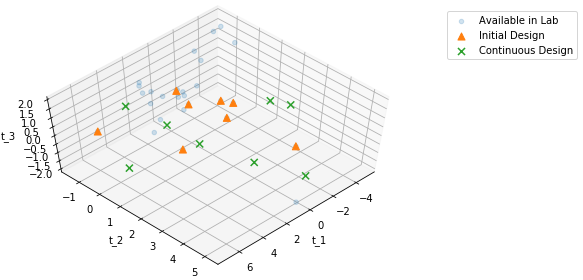

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# fig, ax = plt.subplots()
fig.tight_layout()
# ax.scatter(pcs_practical[:, 0], pcs_practical[:, 1], pcs_practical[:,2],
#            label='Boiling Point between 80°C and 140°C',
#            alpha=0.2)
solvent_lab = solvent_ds_lab_removed.data_to_numpy()
ax.scatter(solvent_lab[:, 0], solvent_lab[:,1], solvent_lab[:,2], label="Available in Lab", alpha=0.2)
experiments_pcs_values = design_lab.get_values('solvent')
continuous_design = [design_lab.get_values(f"test_{i}") for i in range(1,4)]
ax.scatter(experiments_pcs_values[:,0], experiments_pcs_values[:, 1], experiments_pcs_values[:, 2],
           label='Initial Design', marker='^', s=50, alpha=1)
ax.scatter(continuous_design[0], continuous_design[1], continuous_design[2],
           label='Continuous Design', marker='x', s=50, alpha=1)
ax.view_init(60, 45)
ax.set_xlabel('t_1'); ax.set_ylabel('t_2'); ax.set_zlabel('t_3')
ax.legend(bbox_to_anchor=(1.4, 1.0))
# ax.spines['left'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_color('none')
plt.savefig('outputs/initial_design_pca.png')
plt.savefig('outputs/initial_design_pca.svg')
plt.show()